## Stock Price Prediction with Sentiment Analysis

In [1]:
# %%time
# !pip install charset-normalizer pandas_ta yfinance statsmodels tqdm scikit-learn tensorflow

In [2]:
%%time
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

CPU times: user 3.54 ms, sys: 3.46 ms, total: 6.99 ms
Wall time: 6.24 ms


In [3]:
%%time
# Import the necessary libraries and modules
import os
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from statsmodels.tsa.stattools import adfuller

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut
import time
import keras_tuner as kt
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas_datareader.data as web

/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


CPU times: user 5.38 s, sys: 918 ms, total: 6.3 s
Wall time: 7.43 s


In [4]:
%%time
start_time = time.time()
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.makedirs(cfg.DATASET_DIR, exist_ok=True)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/sandy/PycharmProjects/stock_market_analysis
CPU times: user 251 µs, sys: 143 µs, total: 394 µs
Wall time: 402 µs


In [5]:
%%time
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Set memory growth to be the same for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(
            f"✅ {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured with memory growth."
        )

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")
else:
    print("🤷 No GPU detected. TensorFlow will run on CPU.")

✅ 1 Physical GPUs, 1 Logical GPUs configured with memory growth.
CPU times: user 1.37 ms, sys: 1.25 ms, total: 2.62 ms
Wall time: 2.43 ms


I0000 00:00:1753830278.924027 1122403 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753830278.924052 1122403 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Load and Analyze News Data

In [6]:
%%time
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(
        sentiment_csv_path, index_col="Date", parse_dates=True
    )

print("Sentiment data ready.")

Loading existing sentiment data from Dataset/NVDA_daily_sentiment.csv...
Sentiment data ready.
CPU times: user 3.39 ms, sys: 1.02 ms, total: 4.41 ms
Wall time: 4.06 ms


### Fetch Stock Data and Calculate Technical Indicators

In [7]:
%%time
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)

stock_filename = f"{cfg.STOCK_SYMBOL}_stock_data_{START_DATE}_to_{END_DATE}.csv"
stock_csv_path = os.path.join(cfg.DATASET_DIR, stock_filename)

if cfg.UPDATE_STOCK_CSV or not os.path.exists(stock_csv_path):
    print(f"Fetching new stock data from yfinance ({START_DATE} to {END_DATE})...")
    stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
    if stock_data is not None:
        stock_data.to_csv(stock_csv_path)
        print(f"Stock data saved to {stock_csv_path}")
else:
    print(f"Loading existing stock data from {stock_csv_path}...")
    stock_data = pd.read_csv(stock_csv_path, index_col="Date", parse_dates=True)
    stock_data.index = stock_data.index.tz_localize('UTC')

if stock_data.index.tz is None:
    # If index is naive (from CSV), localize it to UTC
    print("Localizing naive index to UTC...")
    stock_data.index = stock_data.index.tz_localize('UTC')
else:
    # If index is already aware (from yfinance), convert it to UTC
    print("Converting timezone-aware index to UTC...")
    stock_data.index = stock_data.index.tz_convert('UTC')

Fetching new stock data from yfinance (2010-03-03 to 2020-06-10)...
\n📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data.
Stock data saved to Dataset/NVDA_stock_data_2010-03-03_to_2020-06-10.csv
Converting timezone-aware index to UTC...
CPU times: user 59.4 ms, sys: 23.5 ms, total: 82.9 ms
Wall time: 461 ms


#### Macroeconomic Data from FRED

In [8]:
%%time
if stock_data is not None:
    print("\n--- Fetching and Merging Macroeconomic Data ---")

    # Define the FRED series codes and their new column names
    fred_series = {
        'CPIAUCSL': 'Inflation_CPI',
        'FEDFUNDS': 'Interest_Rate',
        'UNRATE': 'Unemployment_Rate'
    }

    # Fetch the data from FRED
    macro_data = web.DataReader(list(fred_series.keys()), 'fred', START_DATE, END_DATE)
    macro_data = macro_data.rename(columns=fred_series)

    stock_data.index = stock_data.index.tz_localize(None)

    # Forward-fill to align monthly macro data with daily stock data
    macro_data_daily = macro_data.reindex(stock_data.index, method='ffill')

    # Merge the data
    stock_data = stock_data.join(macro_data_daily)

    # Fill any NaNs at the beginning
    stock_data.bfill(inplace=True)
    print("Macroeconomic features merged successfully.")


--- Fetching and Merging Macroeconomic Data ---
Macroeconomic features merged successfully.
CPU times: user 15.6 ms, sys: 2.27 ms, total: 17.9 ms
Wall time: 180 ms


In [9]:
# Calculate technical indicators from the loaded/fetched data
tech_data = dp.calculate_technical_indicators(stock_data)
print("Technical indicators calculated.")

Technical indicators calculated.


#### VIX (Volatility Index) Data

In [10]:
## Add VIX (Volatility Index) Data
import yfinance as yf

print("--- Applying Final Fix: Normalizing Dates ---")
try:
    # 1. Standardize tech_data index to UTC
    if tech_data.index.tz is None:
        tech_data.index = tech_data.index.tz_localize('UTC')
    else:
        tech_data.index = tech_data.index.tz_convert('UTC')

    # 2. Standardize VIX data index to UTC
    vix_data = yf.Ticker('^VIX').history(start=START_DATE, end=END_DATE)
    vix_data.index = vix_data.index.tz_convert('UTC')

    # --- NEW FIX: NORMALIZE BOTH INDEXES TO MIDNIGHT ---
    print("\nNormalizing indexes to match on date alone...")
    tech_data.index = tech_data.index.normalize()
    vix_data.index = vix_data.index.normalize()
    print(f"-> Normalized tech_data index starts: {tech_data.index[0]}")
    print(f"-> Normalized VIX index starts:    {vix_data.index[0]}")

    # 3. Perform the join on the normalized indexes
    print("\nJoining dataframes...")
    vix_close = vix_data[['Close']].rename(columns={'Close': 'VIX_Close'})
    tech_data = tech_data.join(vix_close)

    # 4. Check the result
    nan_count = tech_data['VIX_Close'].isna().sum()
    total_count = len(tech_data)
    print(f"\nAfter join, VIX_Close has {nan_count} NaN values out of {total_count} rows.")

    if nan_count == total_count:
        print("-> WARNING: Join still resulted in all NaN values.")
    else:
        print("-> SUCCESS: Join completed with matching dates.")

    # Fill any remaining NaNs (from non-trading days)
    tech_data.ffill(inplace=True)
    tech_data.bfill(inplace=True)

    print("\n--- VIX Feature Added Successfully ---")

except Exception as e:
    print(f"\n--- AN ERROR OCCURRED ---")
    import traceback
    traceback.print_exc()

--- Applying Final Fix: Normalizing Dates ---

Normalizing indexes to match on date alone...
-> Normalized tech_data index starts: 2010-12-14 00:00:00+00:00
-> Normalized VIX index starts:    2010-03-03 00:00:00+00:00

Joining dataframes...

After join, VIX_Close has 0 NaN values out of 2387 rows.
-> SUCCESS: Join completed with matching dates.

--- VIX Feature Added Successfully ---


In [11]:
%%time
print("--- Checking for Stationarity of the 'Close' Price ---")

adf_result = adfuller(tech_data['Close'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] > 0.05:
    print("Result: The 'Close' price series is likely non-stationary (p-value > 0.05)")
else:
    print("Result: The 'Close' price series is likely stationary (p-value <= 0.05)")

--- Checking for Stationarity of the 'Close' Price ---
ADF Statistic: 1.1466694971430014
p-value: 0.9955958906997777
Result: The 'Close' price series is likely non-stationary (p-value > 0.05)
CPU times: user 34.8 ms, sys: 9.25 ms, total: 44.1 ms
Wall time: 38.8 ms


In [12]:
%%time
# Calculate daily returns, which will be our new target variable
print("--- Calculating Daily Returns ---")
tech_data['Returns'] = tech_data['Close'].pct_change()
tech_data = tech_data.dropna() # Drop the first row which will have a NaN return
print("'Returns' column created.")

enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
# Recalculate returns for the enhanced dataset as well
if enhanced_full_data is not None:
    enhanced_full_data['Returns'] = enhanced_full_data['Close'].pct_change()
    enhanced_full_data = enhanced_full_data.dropna()

--- Calculating Daily Returns ---
'Returns' column created.

🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2386, 42)
CPU times: user 3.93 ms, sys: 1.11 ms, total: 5.04 ms
Wall time: 4.24 ms


In [13]:
ut.save_dataframe(tech_data, f'{cfg.OUTPUT_DIR}/' + cfg.STOCK_SYMBOL + "_technical_indicators.csv")

DataFrame saved to Output/NVDA_technical_indicators.csv


### Prepare Data for LSTM & SVM Models

In [14]:
%%time
# Prepare data for models using only technical indicators
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = (
    mdl.prepare_data_for_lstm(
        tech_data,
        cfg.BASELINE_FEATURES,
        cfg.BASELINE_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)

# Prepare data for models using sentiment + technical indicators
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = (
    mdl.prepare_data_for_lstm(
        enhanced_full_data,
        cfg.ENHANCED_FEATURES,
        cfg.ENHANCED_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)


🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2386, 42)
CPU times: user 7.73 ms, sys: 1.77 ms, total: 9.51 ms
Wall time: 8.7 ms


### Single Layer LSTM Models

In [15]:
%%time
print("\n--- Tuning Single-Layer LSTM Model ---")

# Define the input shape from your training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner, passing the input_shape to the model builder
tuner_single_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="single_layer_lstm",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting hyperparameter search...")
tuner_single_lstm.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_single_lstm = tuner_single_lstm.get_best_hyperparameters(num_trials=1)[0]
single_lstm_model = tuner_single_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Single-Layer LSTM:
Units: {best_hps_single_lstm.get('units')}
Dropout: {best_hps_single_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_single_lstm.get('learning_rate')}
---
"""
)


--- Tuning Single-Layer LSTM Model ---
Reloading Tuner from tuner_results/single_layer_lstm/tuner0.json
Starting hyperparameter search...

Hyperparameter search complete.

---
Optimal Hyperparameters for Single-Layer LSTM:
Units: 64
Dropout: 0.40
Learning Rate: 0.01
---

CPU times: user 371 ms, sys: 55.3 ms, total: 426 ms
Wall time: 435 ms



--- Evaluating Best Single-Layer LSTM Model ---
{'Model': 'Single-Layer LSTM', 'RMSE': np.float64(0.039521069008129704), 'MAE': 0.02722003190155601, 'MAPE (%)': np.float64(39821.71440976384), 'R-squared': -0.2566991890526309, 'Directional_Accuracy': np.float64(74.36974789915966), 'MASE': np.float64(0.5324582140446315)}
Plot saved to Output/NVDA_Single-Layer_LSTM_analysis.png


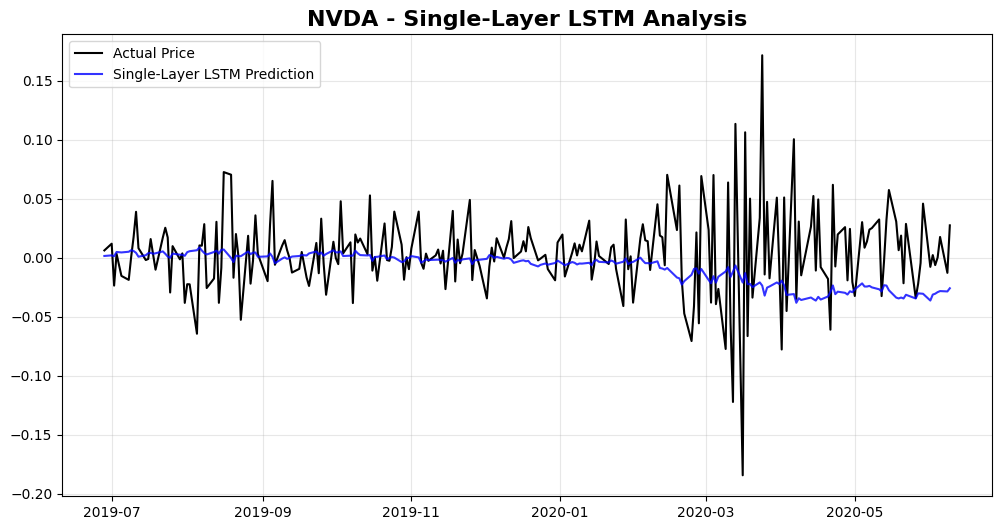

CPU times: user 321 ms, sys: 33.5 ms, total: 354 ms
Wall time: 374 ms


In [16]:
%%time
# --- Evaluation using the best model ---
print("\n--- Evaluating Best Single-Layer LSTM Model ---")
single_layer_lstm_preds = single_lstm_model.predict(X_test_tech, verbose=0)

# Re-create the scaler based on the training data's 'Returns' price
close_scaler = MinMaxScaler()
close_scaler.fit(tech_data[["Returns"]][: len(X_train_tech)])  # Fit only on the training part

# Inverse transforms the actual and predicted values
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_preds_scaled = close_scaler.inverse_transform(single_layer_lstm_preds)

# Calculate and print metrics
baseline_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_preds_scaled, "Single-Layer LSTM", y_train_tech
)
print(baseline_metrics)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Single-Layer LSTM",
)

### Multi Layer LSTM Models

In [17]:
%%time
print("\n--- Tuning Multi-Layer LSTM Model ---")

# Define the input shape from our training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner
tuner_multi_lstm = kt.Hyperband(
    # Pass the input_shape to the model-building function
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="multi_layer_lstm",  # New project name to store results separately
    overwrite=False,
)

# Define a callback to stop training early if val_loss isn't improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting hyperparameter search...")
tuner_multi_lstm.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm = tuner_multi_lstm.get_best_hyperparameters(num_trials=1)[0]
multi_layer_model = tuner_multi_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer LSTM:
Units Layer 1: {best_hps_multi_lstm.get('units_1')}
Units Layer 2: {best_hps_multi_lstm.get('units_2')}
Dropout: {best_hps_multi_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm.get('learning_rate')}
---
"""
)


--- Tuning Multi-Layer LSTM Model ---
Reloading Tuner from tuner_results/multi_layer_lstm/tuner0.json
Starting hyperparameter search...

Hyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer LSTM:
Units Layer 1: 128
Units Layer 2: 32
Dropout: 0.30
Learning Rate: 0.01
---

CPU times: user 435 ms, sys: 44.9 ms, total: 480 ms
Wall time: 494 ms



--- Evaluating Best Multi-Layer LSTM Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Multi-Layer_LSTM_analysis.png


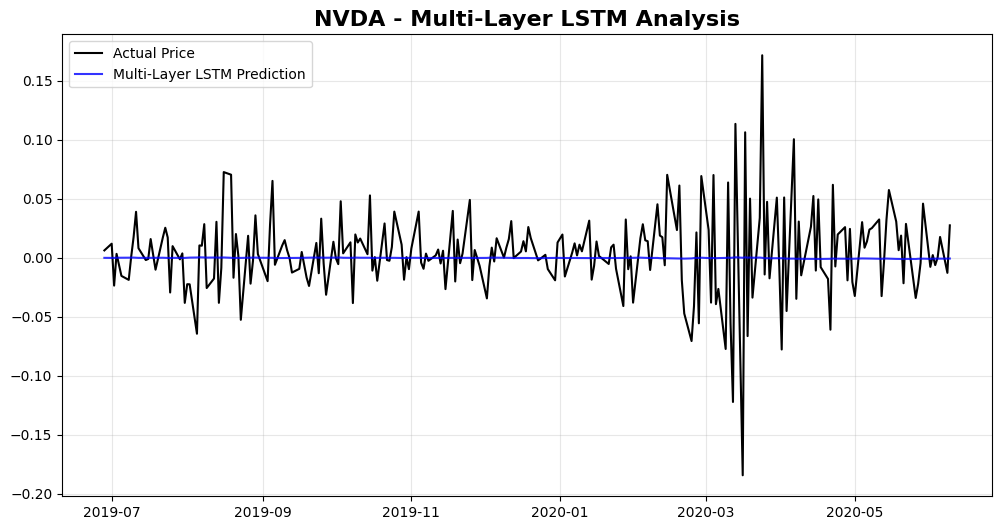

{'Model': 'Multi-Layer LSTM', 'RMSE': np.float64(0.035502510829824946), 'MAE': 0.024410323047822154, 'MAPE (%)': np.float64(5214.486537859758), 'R-squared': -0.014126439185558448, 'Directional_Accuracy': np.float64(77.31092436974791), 'MASE': np.float64(0.47749675905239847)}
CPU times: user 396 ms, sys: 37.7 ms, total: 434 ms
Wall time: 450 ms


In [18]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Multi-Layer LSTM Model ---")
multi_preds = multi_layer_model.predict(X_test_tech, verbose=0)

# We can reuse the same scaler fitted before
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
multi_preds_scaled = close_scaler.inverse_transform(multi_preds)

multi_layer_metrics = ut.calculate_metrics(
    y_test_tech_scaled, multi_preds_scaled, "Multi-Layer LSTM", y_train_tech
)
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_tech_scaled,
    multi_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Multi-Layer LSTM",
)

print(multi_layer_metrics)

### Single-Layer Enhanced LSTM Model

In [19]:
%%time
print("\n--- Tuning Single-Layer Enhanced LSTM Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner
tuner_enh_single_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_single_layer_lstm",
    overwrite=False,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the ENHANCED data
print("Starting hyperparameter search on enhanced data...")
tuner_enh_single_lstm.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_single = tuner_enh_single_lstm.get_best_hyperparameters(num_trials=1)[0]
enhanced_model = tuner_enh_single_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Enhanced Single-Layer LSTM:
Units: {best_hps_enh_single.get('units')}
Dropout: {best_hps_enh_single.get('dropout'):.2f}
Learning Rate: {best_hps_enh_single.get('learning_rate')}
---
"""
)


--- Tuning Single-Layer Enhanced LSTM Model ---
Reloading Tuner from tuner_results/enhanced_single_layer_lstm/tuner0.json
Starting hyperparameter search on enhanced data...
\nHyperparameter search complete.

---
Optimal Hyperparameters for Enhanced Single-Layer LSTM:
Units: 128
Dropout: 0.10
Learning Rate: 0.01
---

CPU times: user 346 ms, sys: 28.1 ms, total: 374 ms
Wall time: 377 ms



--- Evaluating Best Enhanced Single-Layer LSTM Model ---
Plotting results for the best enhanced model...
Plot saved to Output/NVDA_Enhanced_LSTM_analysis.png


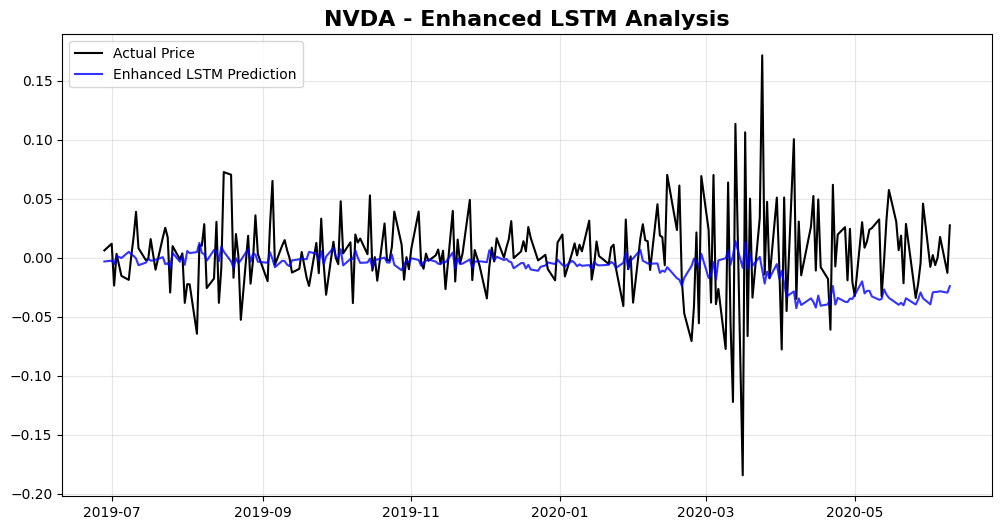

{'Model': 'Enhanced LSTM', 'RMSE': np.float64(0.039448592089679366), 'MAE': 0.027718613129665545, 'MAPE (%)': np.float64(85555.90067951856), 'R-squared': -0.25209414316384615, 'Directional_Accuracy': np.float64(70.58823529411765), 'MASE': np.float64(0.5422110927787746)}
CPU times: user 303 ms, sys: 27.6 ms, total: 331 ms
Wall time: 342 ms


In [20]:
%%time
print("\n--- Evaluating Best Enhanced Single-Layer LSTM Model ---")
enh_preds = enhanced_model.predict(X_test_enh, verbose=0)

# IMPORTANT: Use the scaler that was fitted to the enhanced data
close_scaler_enh = MinMaxScaler().fit(enhanced_full_data[["Returns"]][: len(X_train_enh)])

y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = close_scaler_enh.inverse_transform(enh_preds)

enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_preds_scaled, "Enhanced LSTM", y_train_enh
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled):]

# Plot the results
print("Plotting results for the best enhanced model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced LSTM",
)

print(enhanced_metrics)

### Multi-Layer Enhanced LSTM Model

In [21]:
%%time
print("\n--- Tuning Multi-Layer Enhanced LSTM Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner
tuner_enh_multi_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_multi_layer_lstm",
    overwrite=False,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the ENHANCED data
print("Starting hyperparameter search on enhanced data...")
tuner_enh_multi_lstm.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_multi = tuner_enh_multi_lstm.get_best_hyperparameters(num_trials=1)[0]
multi_enhanced_model = tuner_enh_multi_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer Enhanced LSTM:
Units Layer 1: {best_hps_enh_multi.get('units_1')}
Units Layer 2: {best_hps_enh_multi.get('units_2')}
Dropout: {best_hps_enh_multi.get('dropout'):.2f}
Learning Rate: {best_hps_enh_multi.get('learning_rate')}
---
"""
)


--- Tuning Multi-Layer Enhanced LSTM Model ---
Reloading Tuner from tuner_results/enhanced_multi_layer_lstm/tuner0.json
Starting hyperparameter search on enhanced data...
\nHyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer Enhanced LSTM:
Units Layer 1: 192
Units Layer 2: 64
Dropout: 0.50
Learning Rate: 0.01
---

CPU times: user 446 ms, sys: 47 ms, total: 493 ms
Wall time: 504 ms



--- Evaluating Best Multi-Layer Enhanced LSTM Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Multi-Layer_Enhanced_LSTM_analysis.png


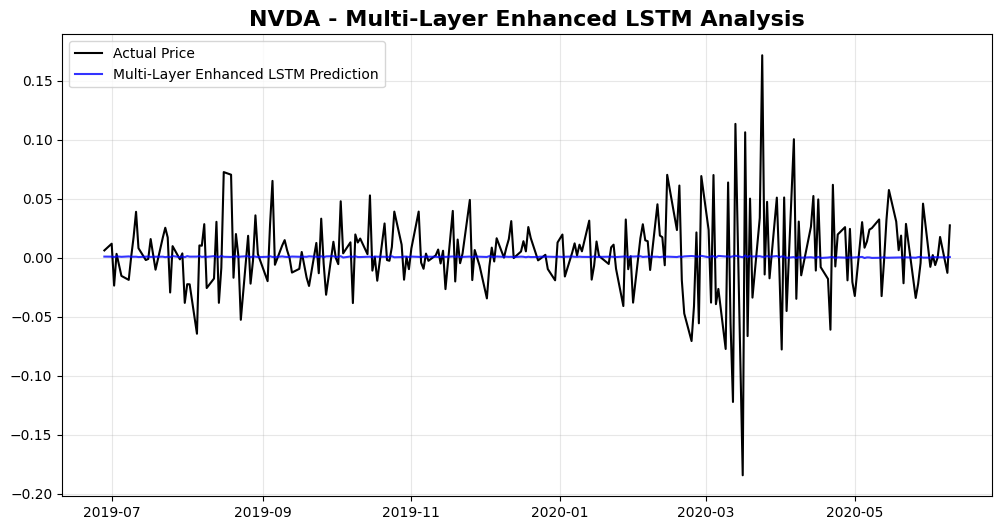

{'Model': 'Multi-Layer Enhanced LSTM', 'RMSE': np.float64(0.035364623046975664), 'MAE': 0.024289941165385364, 'MAPE (%)': np.float64(27184.142696628107), 'R-squared': -0.006264229445576364, 'Directional_Accuracy': np.float64(66.38655462184873), 'MASE': np.float64(0.47514193734030635)}
CPU times: user 423 ms, sys: 45.4 ms, total: 469 ms
Wall time: 488 ms


In [22]:
%%time
# Proceed with evaluation using the best ENHANCED model
print("\n--- Evaluating Best Multi-Layer Enhanced LSTM Model ---")
multi_enh_preds = multi_enhanced_model.predict(X_test_enh, verbose=0)

# We can reuse the same scaler fitted for the enhanced data
y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
multi_enh_preds_scaled = close_scaler_enh.inverse_transform(multi_enh_preds)

multi_enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, multi_enh_preds_scaled, "Multi-Layer Enhanced LSTM", y_train_enh
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    multi_enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Enhanced LSTM",
)

print(multi_enhanced_metrics)

### Support Vector Machine (SVM) Models

In [23]:
%%time
print("\n--- Preparing Data and Tuning SVM Model ---")
# SVM requires 2D input, so we flatten the sequence data
nsamples, nx, ny = X_train_tech.shape
X_train_svm_tech = X_train_tech.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_tech.shape
X_test_svm_tech = X_test_tech.reshape((nsamples, nx * ny))

print(f"Reshaped baseline data for SVM: {X_train_svm_tech.shape}")


--- Preparing Data and Tuning SVM Model ---
Reshaped baseline data for SVM: (2117, 510)
CPU times: user 155 µs, sys: 30 µs, total: 185 µs
Wall time: 160 µs


Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/envs/tf_metal/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/tf_metal/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/tf_metal/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or

[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........C=1, epsil

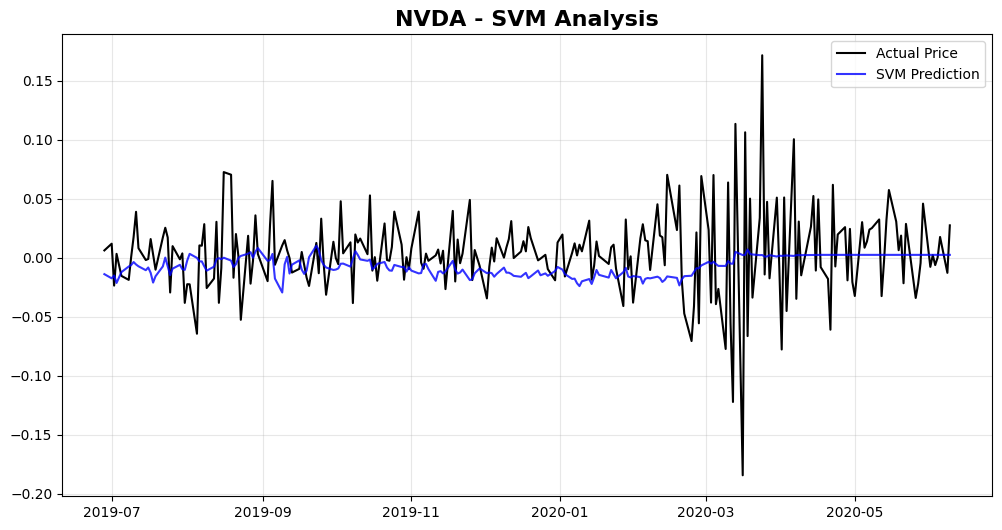

{'Model': 'SVM', 'RMSE': np.float64(0.0371808383955566), 'MAE': 0.02738285818955651, 'MAPE (%)': np.float64(353289.6102845899), 'R-squared': -0.11227538223641642, 'Directional_Accuracy': np.float64(52.10084033613446), 'MASE': np.float64(0.53564330195422)}
CPU times: user 258 ms, sys: 196 ms, total: 455 ms
Wall time: 4.61 s


In [24]:
%%time
# Build and train the SVM by running the grid search
baseline_svm_model = mdl.build_and_train_svm(X_train_svm_tech, y_train_tech)

# Evaluate the best model found by the tuner
print("\n--- Evaluating Best SVM Model ---")
base_svm_preds = baseline_svm_model.predict(X_test_svm_tech)

base_svm_preds_scaled = close_scaler.inverse_transform(base_svm_preds.reshape(-1, 1))
baseline_svm_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_svm_preds_scaled, "SVM", y_train_tech
)

# Plot the results
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_svm_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "SVM",
)

print(baseline_svm_metrics)

### Enhanced Support Vector Machine (SVM) Models

In [25]:
%%time
print("\n--- Preparing Enhanced Data and Tuning Enhanced SVM Model ---")
# Reshape the enhanced data for SVM's 2D input requirement
nsamples, nx, ny = X_train_enh.shape
X_train_svm_enh = X_train_enh.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_enh.shape
X_test_svm_enh = X_test_enh.reshape((nsamples, nx * ny))

print(f"Reshaped enhanced data for SVM: {X_train_svm_enh.shape}")


--- Preparing Enhanced Data and Tuning Enhanced SVM Model ---
Reshaped enhanced data for SVM: (2117, 630)
CPU times: user 137 µs, sys: 83 µs, total: 220 µs
Wall time: 188 µs


Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.

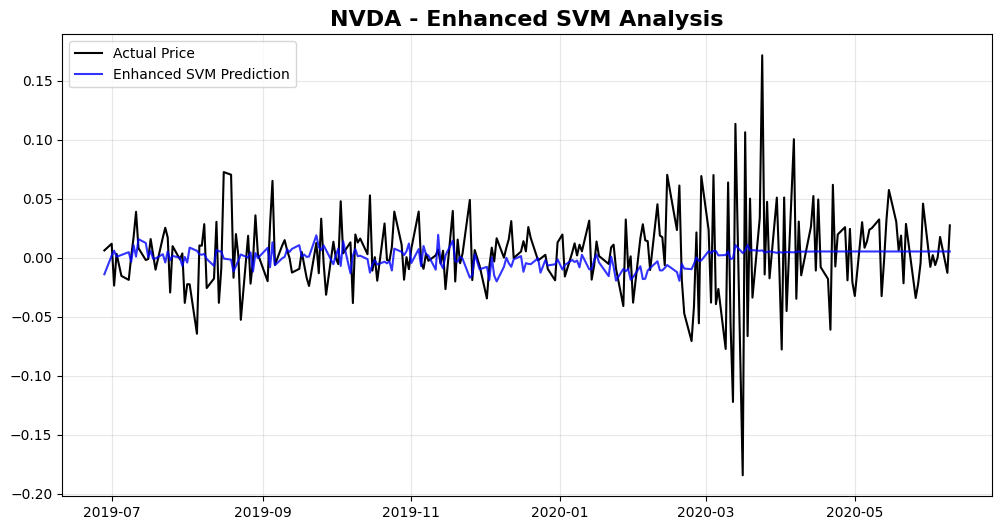

{'Model': 'Enhanced SVM', 'RMSE': np.float64(0.0360358773618927), 'MAE': 0.02554795400933415, 'MAPE (%)': np.float64(326092.999813105), 'R-squared': -0.044826474852066145, 'Directional_Accuracy': np.float64(46.63865546218487), 'MASE': np.float64(0.49975025795347533)}
CPU times: user 374 ms, sys: 31.1 ms, total: 405 ms
Wall time: 1.8 s


In [26]:
%%time
# Build and train the enhanced SVM by running the grid search
enhanced_svm_model = mdl.build_and_train_svm(X_train_svm_enh, y_train_enh)

# Evaluate the best model found by the tuner
print("\n--- Evaluating Best Enhanced SVM Model ---")
enh_svm_preds = enhanced_svm_model.predict(X_test_svm_enh)

# Use the scaler fitted on the enhanced data to inverse the transformation
enh_svm_preds_scaled = close_scaler_enh.inverse_transform(enh_svm_preds.reshape(-1, 1))
enhanced_svm_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_svm_preds_scaled, "Enhanced SVM", y_train_tech
)

# Plot the results
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_svm_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced SVM",
)

print(enhanced_svm_metrics)

### GRU Model

In [27]:
%%time
print("\n--- Tuning Baseline GRU Model ---")

# Define the input shape from our baseline training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the GRU model
tuner_base_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_gru",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting GRU hyperparameter search...")
tuner_base_gru.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_base_gru = tuner_base_gru.get_best_hyperparameters(num_trials=1)[0]
baseline_gru_model = tuner_base_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: {best_hps_base_gru.get('units_1')}
Units Layer 2: {best_hps_base_gru.get('units_2')}
Dropout: {best_hps_base_gru.get('dropout'):.2f}
Learning Rate: {best_hps_base_gru.get('learning_rate')}
---
"""
)


--- Tuning Baseline GRU Model ---
Reloading Tuner from tuner_results/baseline_gru/tuner0.json
Starting GRU hyperparameter search...
\nHyperparameter search complete.

---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: 192
Units Layer 2: 128
Dropout: 0.30
Learning Rate: 0.01
---

CPU times: user 416 ms, sys: 104 ms, total: 520 ms
Wall time: 567 ms



--- Evaluating Best Baseline GRU Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Baseline_GRU_analysis.png


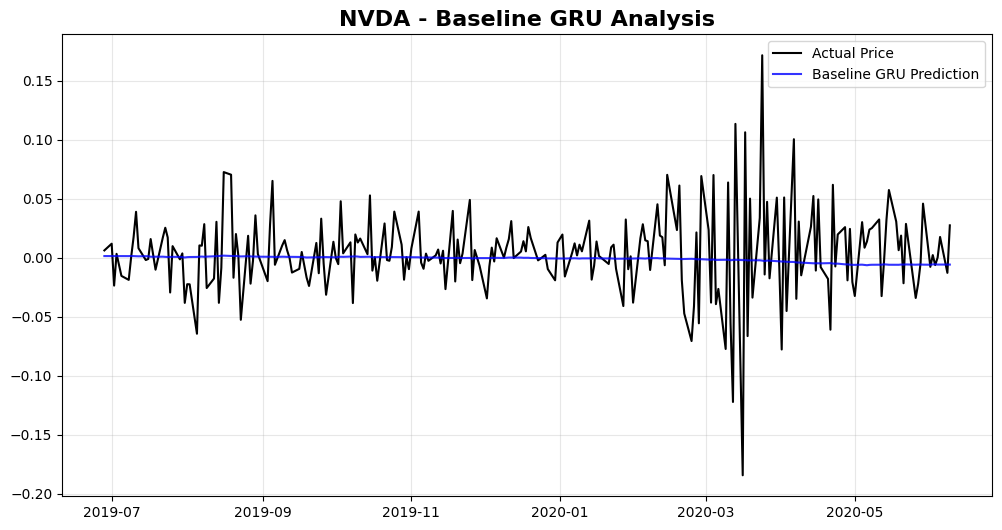

{'Model': 'Baseline GRU', 'RMSE': np.float64(0.03578285833843884), 'MAE': 0.02455206665354472, 'MAPE (%)': np.float64(13483.726833801753), 'R-squared': -0.0302058848394946, 'Directional_Accuracy': np.float64(62.18487394957983), 'MASE': np.float64(0.48026944306056707)}
CPU times: user 355 ms, sys: 39.6 ms, total: 395 ms
Wall time: 416 ms


In [28]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Baseline GRU Model ---")
base_gru_preds = baseline_gru_model.predict(X_test_tech, verbose=0)

y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_gru_preds_scaled = close_scaler.inverse_transform(base_gru_preds)

baseline_gru_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_gru_preds_scaled, "Baseline GRU", y_train_tech
)
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_gru_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Baseline GRU",
)

print(baseline_gru_metrics)

### Enhanced GRU Model

In [29]:
%%time
print("\n--- Tuning Enhanced GRU Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the Enhanced GRU model
tuner_enh_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_gru",  # New project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the enhanced data
print("Starting Enhanced GRU hyperparameter search...")
tuner_enh_gru.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_gru = tuner_enh_gru.get_best_hyperparameters(num_trials=1)[0]
enhanced_gru_model = tuner_enh_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Enhanced GRU:
Units Layer 1: {best_hps_enh_gru.get('units_1')}
Units Layer 2: {best_hps_enh_gru.get('units_2')}
Dropout: {best_hps_enh_gru.get('dropout'):.2f}
Learning Rate: {best_hps_enh_gru.get('learning_rate')}
---
"""
)


--- Tuning Enhanced GRU Model ---
Reloading Tuner from tuner_results/enhanced_gru/tuner0.json
Starting Enhanced GRU hyperparameter search...
\nHyperparameter search complete.

---
Optimal Hyperparameters for Enhanced GRU:
Units Layer 1: 256
Units Layer 2: 32
Dropout: 0.30
Learning Rate: 0.01
---

CPU times: user 411 ms, sys: 38.6 ms, total: 450 ms
Wall time: 459 ms



--- Evaluating Best Enhanced GRU Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Enhanced_GRU_analysis.png


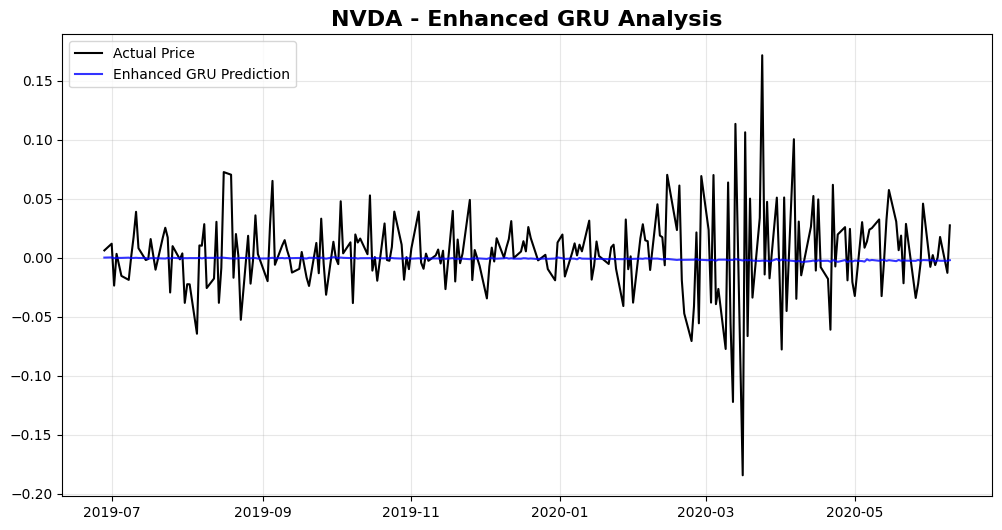

{'Model': 'Enhanced GRU', 'RMSE': np.float64(0.03561298300544122), 'MAE': 0.024441158961123605, 'MAPE (%)': np.float64(23807.829148255252), 'R-squared': -0.020447516544130462, 'Directional_Accuracy': np.float64(63.4453781512605), 'MASE': np.float64(0.4780999484749644)}
CPU times: user 354 ms, sys: 34.7 ms, total: 389 ms
Wall time: 398 ms


In [30]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Enhanced GRU Model ---")
enh_gru_preds = enhanced_gru_model.predict(X_test_enh, verbose=0)

y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_gru_preds_scaled = close_scaler_enh.inverse_transform(enh_gru_preds)

enhanced_gru_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_gru_preds_scaled, "Enhanced GRU", y_train_tech
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_gru_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced GRU",
)

print(enhanced_gru_metrics)

### ARIMA Model


--- Finding Best ARIMA Order ---
Searching for the best ARIMA order...
Best ARIMA order found: (0, 0, 0) with AIC: -9662.14


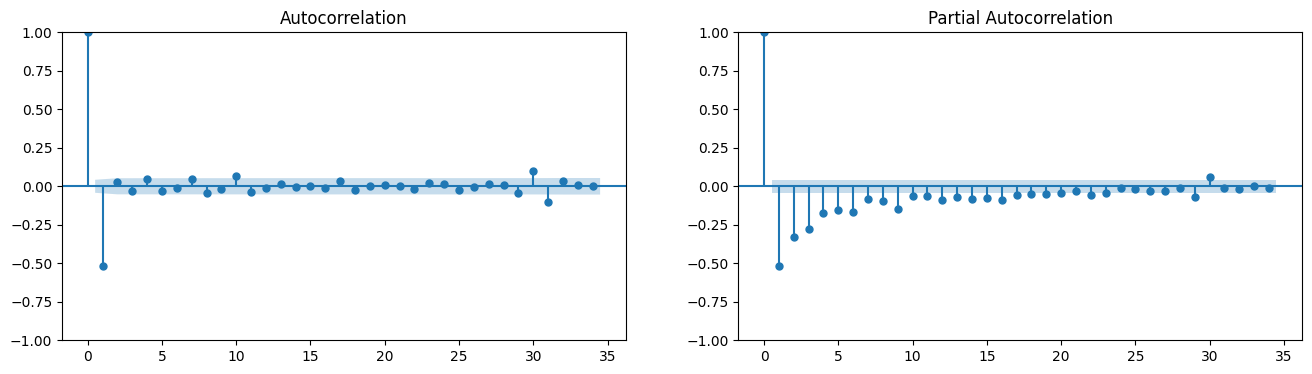

CPU times: user 9.28 s, sys: 87 ms, total: 9.36 s
Wall time: 9.38 s


In [31]:
%%time
print("\n--- Finding Best ARIMA Order ---")
# ARIMA works on the unscaled, 1D time series of the target variable
close_prices = tech_data[cfg.BASELINE_TARGET]
train_size = int(len(close_prices) * (1 - cfg.TEST_SIZE))
train_arima, test_arima = close_prices[0:train_size], close_prices[train_size:]

# Find the best order using our new function
best_arima_order = mdl.find_best_arima_order(train_arima)

# Plot ACF and PACF for visual inspection
# This helps to manually verify the p and q values.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(train_arima.diff().dropna(), ax=axes[0])
plot_pacf(train_arima.diff().dropna(), ax=axes[1], method="ywm")
plt.show()

In [32]:
%%time
print(f"\n--- Running ARIMA Model with best order {best_arima_order} ---")

history = [x for x in train_arima]
arima_predictions = []

print(f"Performing rolling forecast for {len(test_arima)} steps...")
# The tqdm library provides a progress bar, which is useful here

for t in tqdm(range(len(test_arima))):
    # Use the best order found previously for every forecast
    model_arima = mdl.build_and_train_arima(history, order=best_arima_order)
    output = model_arima.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_arima[t]
    history.append(obs)

print("ARIMA forecast complete.")


--- Running ARIMA Model with best order (0, 0, 0) ---
Performing rolling forecast for 239 steps...


  1%|          | 2/239 [00:00<00:19, 12.36it/s]/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 239/239 [00:27<00:00,  8.61it/s]

ARIMA forecast complete.
CPU times: user 27.4 s, sys: 360 ms, total: 27.8 s
Wall time: 27.8 s


Plot saved to Output/NVDA_ARIMA_analysis.png


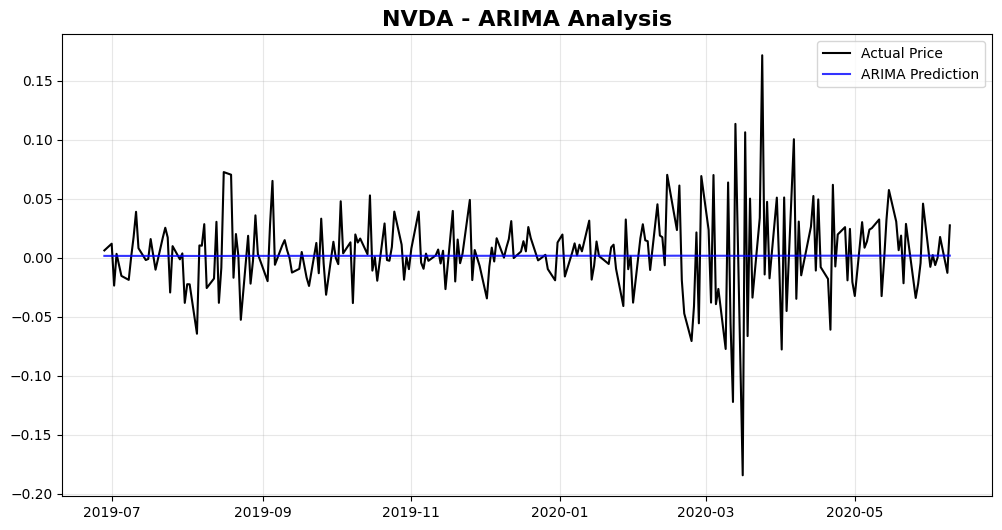

{'Model': 'ARIMA', 'RMSE': np.float64(0.03534135723409026), 'MAE': 0.02427696968363491, 'MAPE (%)': np.float64(64325.80692688967), 'R-squared': -0.004940655081280054, 'Directional_Accuracy': np.float64(24.789915966386555), 'MASE': np.float64(0.9678974876503095)}
CPU times: user 108 ms, sys: 4.96 ms, total: 113 ms
Wall time: 113 ms


In [33]:
%%time
arima_predictions_np = np.array(arima_predictions).reshape(-1, 1)
y_test_arima_np = np.array(test_arima).reshape(-1, 1)
arima_metrics = ut.calculate_metrics(
    y_test_arima_np, arima_predictions_np, "ARIMA", train_arima
)

ut.plot_non_keras_results(
    y_test_arima_np,
    arima_predictions_np,
    test_arima.index,
    cfg.STOCK_SYMBOL,
    "ARIMA",
)

print(arima_metrics)

### 7. Final Performance Comparison

In [34]:
%%time
naive_preds = np.roll(y_test_tech_scaled, 1)
naive_preds[0] = y_test_tech_scaled[0]
naive_metrics = ut.calculate_metrics(y_test_tech_scaled, naive_preds, "Naive Baseline", y_train_tech)

# --- UPDATED TO INCLUDE ALL MODELS ---
all_metrics_df = pd.DataFrame(
    [
        naive_metrics,
        baseline_metrics,
        enhanced_metrics,
        multi_layer_metrics,
        multi_enhanced_metrics,
        baseline_gru_metrics,
        enhanced_gru_metrics,
        baseline_svm_metrics,
        enhanced_svm_metrics,
        arima_metrics,
    ]
).round(4)

print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 60)
print(all_metrics_df.to_string(index=False))
print("-" * 60)

metrics_to_evaluate = {
    "RMSE": "min",
    "MAE": "min",
    "MAPE (%)": "min",
    "MASE": "min",
    "R-squared": "max",
    "Directional_Accuracy": "max"
}

print("\n🏆 Best Model for Each Metric")
print("-" * 60)
for metric, method in metrics_to_evaluate.items():
    if method == "min":
        # For metrics where lower is better (like RMSE, MAE, MAPE, MASE)
        winner_idx = all_metrics_df[metric].idxmin()
    else:
        # For metrics where higher is better (like R-squared, Directional Accuracy)
        winner_idx = all_metrics_df[metric].idxmax()

    winner_row = all_metrics_df.loc[winner_idx]
    print(f"{metric:<22}: {winner_row['Model']} (Score: {winner_row[metric]:.4f})")
print("-" * 60)


📊 COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------
                    Model   RMSE    MAE    MAPE (%)  R-squared  Directional_Accuracy   MASE
           Naive Baseline 0.0568 0.0381 687892.4716    -1.6002               29.8319 0.7450
        Single-Layer LSTM 0.0395 0.0272  39821.7144    -0.2567               74.3697 0.5325
            Enhanced LSTM 0.0394 0.0277  85555.9007    -0.2521               70.5882 0.5422
         Multi-Layer LSTM 0.0355 0.0244   5214.4865    -0.0141               77.3109 0.4775
Multi-Layer Enhanced LSTM 0.0354 0.0243  27184.1427    -0.0063               66.3866 0.4751
             Baseline GRU 0.0358 0.0246  13483.7268    -0.0302               62.1849 0.4803
             Enhanced GRU 0.0356 0.0244  23807.8291    -0.0204               63.4454 0.4781
                      SVM 0.0372 0.0274 353289.6103    -0.1123               52.1008 0.5356
             Enhanced SVM 0.0360 0.0255 326092.9998    -0.0448         

In [35]:
%%time
ranking_df = all_metrics_df.copy()

# Lower is better for these metrics
ranking_df["RMSE_Rank"] = ranking_df["RMSE"].rank(method="min", ascending=True)
ranking_df["MAE_Rank"] = ranking_df["MAE"].rank(method="min", ascending=True)
ranking_df["MAPE_Rank"] = ranking_df["MAPE (%)"].rank(method="min", ascending=True)
ranking_df["MASE_Rank"] = ranking_df["MASE"].rank(method="min", ascending=True)

# Higher is better for these metrics
ranking_df["DA_Rank"] = ranking_df["Directional_Accuracy"].rank(method="min", ascending=False)
ranking_df["R2_Rank"] = ranking_df["R-squared"].rank(method="min", ascending=False)

# Create a total rank score (e.g., based on the most important metrics)
ranking_df["Total_Rank"] = (
        ranking_df["MASE_Rank"] + ranking_df["MAPE_Rank"] + ranking_df["DA_Rank"]
)

final_ranking = ranking_df.sort_values(by="Total_Rank", ascending=True)

print("\n🏆 Overall Model Ranking (Lower Total_Rank is Better)")
print("-" * 60)
print(
    final_ranking[["Model", "Total_Rank", "RMSE", "MAE", "MAPE (%)", "R-squared", "MASE", "Directional_Accuracy"]]
    .reset_index(drop=True)
    .to_string()
)


🏆 Overall Model Ranking (Lower Total_Rank is Better)
------------------------------------------------------------
                       Model  Total_Rank    RMSE     MAE     MAPE (%)  R-squared    MASE  Directional_Accuracy
0           Multi-Layer LSTM         4.0  0.0355  0.0244    5214.4865    -0.0141  0.4775               77.3109
1  Multi-Layer Enhanced LSTM         9.0  0.0354  0.0243   27184.1427    -0.0063  0.4751               66.3866
2               Enhanced GRU        11.0  0.0356  0.0244   23807.8291    -0.0204  0.4781               63.4454
3               Baseline GRU        12.0  0.0358  0.0246   13483.7268    -0.0302  0.4803               62.1849
4          Single-Layer LSTM        13.0  0.0395  0.0272   39821.7144    -0.2567  0.5325               74.3697
5              Enhanced LSTM        18.0  0.0394  0.0277   85555.9007    -0.2521  0.5422               70.5882
6               Enhanced SVM        21.0  0.0360  0.0255  326092.9998    -0.0448  0.4998               46.63

Plot saved to Output/NVDA_all_models_comparison.png


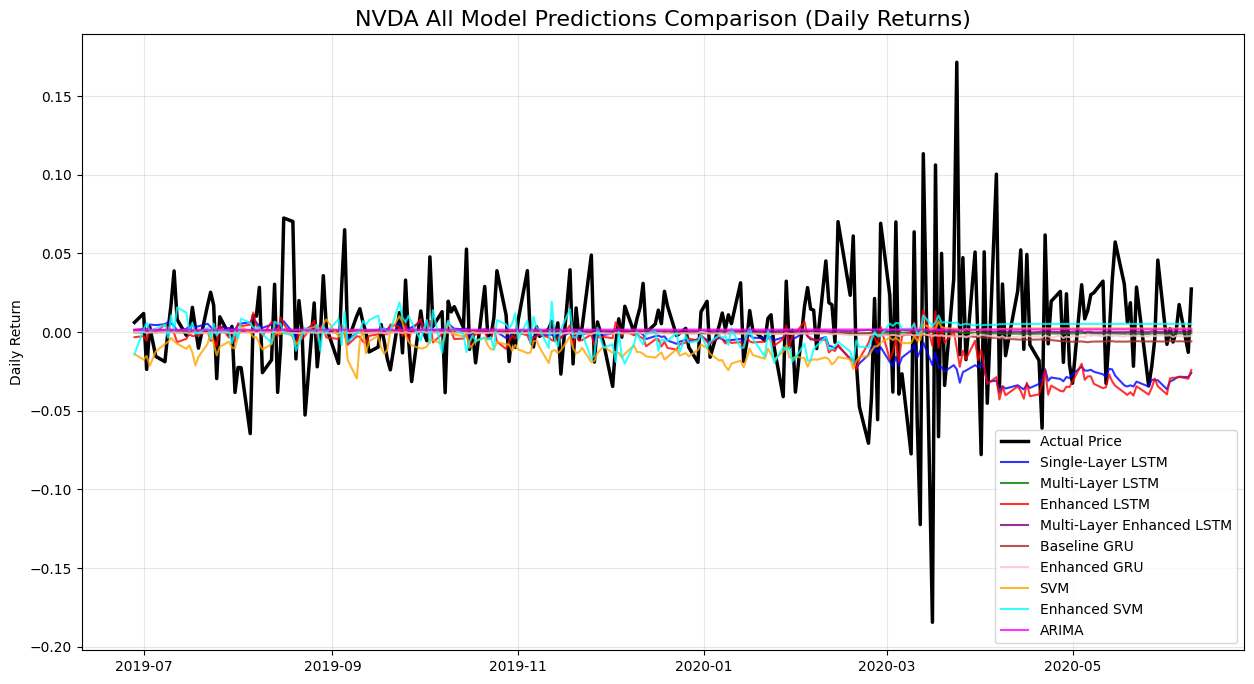

CPU times: user 166 ms, sys: 7.46 ms, total: 174 ms
Wall time: 174 ms


In [36]:
%%time
plot_data = {
    "Actual": {"dates": test_dates_tech, "values": y_test_tech_scaled},
    "Single-Layer LSTM": {"dates": test_dates_tech, "values": base_preds_scaled},
    "Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled},
    "Enhanced LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
    "Multi-Layer Enhanced LSTM": {
        "dates": test_dates_enh,
        "values": multi_enh_preds_scaled,
    },
    "Baseline GRU": {"dates": test_dates_tech, "values": base_gru_preds_scaled},
    "Enhanced GRU": {"dates": test_dates_enh, "values": enh_gru_preds_scaled},
    "SVM": {"dates": test_dates_tech, "values": base_svm_preds_scaled},
    "Enhanced SVM": {"dates": test_dates_enh, "values": enh_svm_preds_scaled},
    "ARIMA": {"dates": test_arima.index, "values": arima_predictions_np},
}

ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL, f"{cfg.STOCK_SYMBOL} All Model Predictions Comparison (Daily Returns)")

Plot saved to Output/NVDA_all_models_comparison.png


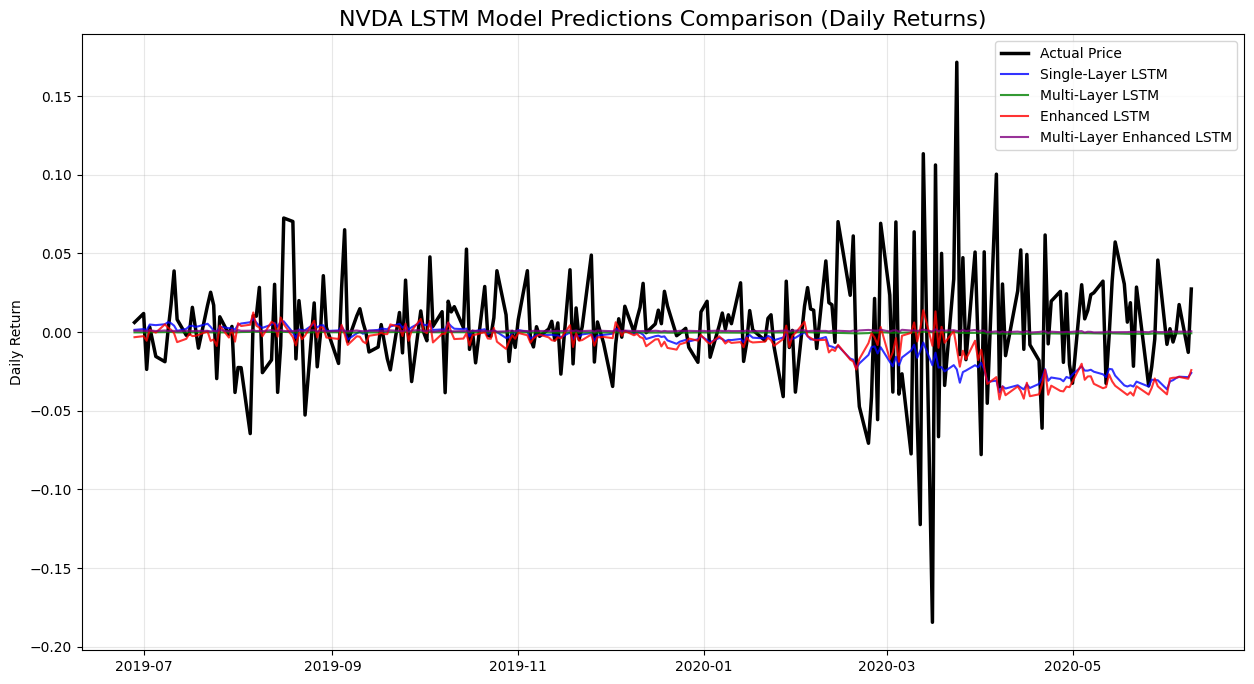

CPU times: user 147 ms, sys: 8.21 ms, total: 156 ms
Wall time: 155 ms


In [37]:
%%time
plot_data = {
    "Actual": {"dates": test_dates_tech, "values": y_test_tech_scaled},
    "Single-Layer LSTM": {"dates": test_dates_tech, "values": base_preds_scaled},
    "Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled},
    "Enhanced LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
    "Multi-Layer Enhanced LSTM": {
        "dates": test_dates_enh,
        "values": multi_enh_preds_scaled,
    },
}

ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL, f"{cfg.STOCK_SYMBOL} LSTM Model Predictions Comparison (Daily Returns)")

In [38]:
try:
    end_time = time.time()
    total_time = end_time - start_time
    print(f"--- Total Notebook Runtime: {ut.format_runtime(total_time)} seconds ---")
except NameError:
    print("⚠️ --- Timer could not be stopped because 'start_time' was not defined.")

--- Total Notebook Runtime: 52.28 seconds seconds ---
